CoNLL-2003 dataset task demonstrates the labeling of tokens for named entity recognition (NER), part-of-speech (POS) tagging, and chunking. Each component of the JSON object corresponds to a different layer of annotation for the sentence:

1. **Tokens**: These are the individual words or punctuation marks from the text. In this case, the sentence "EU rejects German call to boycott British lamb." is split into tokens:
   - "EU"
   - "rejects"
   - "German"
   - "call"
   - "to"
   - "boycott"
   - "British"
   - "lamb"
   - "."

2. **POS Tags**: This array contains the POS tags corresponding to each token. The tags are encoded as numbers, each representing a specific part of speech (like noun, verb, adjective). These numbers usually correspond to a tagging scheme such as the Penn Treebank POS tags:
   - "EU" is tagged as 22, which represents a proper noun.
   - "rejects" is tagged as 42, indicating a verb in present tense.
   - And so forth.

3. **Chunk Tags**: This array indicates phrase chunk boundaries and types (like NP for noun phrase, VP for verb phrase). Each number again corresponds to a specific type of phrase or boundary in a predefined scheme:
   - "EU" is part of a noun phrase, hence 11.
   - "rejects" begins a verb phrase, indicated by 21.
   - The chunk tags help in parsing the sentence into linguistically meaningful phrases.

4. **NER Tags**: These tags are used for named entity recognition. They identify whether each token is part of a named entity (like a person, location, organization) and the type of entity:
   - "EU" is tagged as 3, denoting an organization.
   - "German" and "British" are tagged as 7, indicating nationality or ethnicity.
   - Other tokens are tagged as 0, meaning they are not recognized as part of any named entity.

 Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

In [1]:
!pip install uv
!uv pip install numpy pandas torch transformers datasets scikit-learn umap-learn matplotlib seaborn

Using Python 3.12.3 environment at: /home/jj/github/deepl_nlp/.venv
Audited 9 packages in 18ms
Using Python 3.12.3 environment at: /home/jj/github/deepl_nlp/.venv
Audited 9 packages in 18ms


# Instructions 
1. download the **conll2003** from the following [link]("https://data.deepai.org/conll2003.zip")
2. unzip the file
3. download the glove embeddings from [link]("https://huggingface.co/datasets/SLU-CSCI4750/glove.6B.100d.txt/resolve/main/glove.6B.100d.txt.gz")
4. unzip the glove embeddings file
5. update the constants in the code below to point to the correct file paths on your machine

In [2]:
# basic python data science tooling
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import (
    Dataset, 
    DatasetDict, 
    Features, 
    Sequence, 
    ClassLabel, 
    Value,
)

# progress bar
from tqdm import tqdm


# deep learning stuff
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


# constants for config
LOCAL_DIR = "/home/jj/github/deepl_nlp/assignment1/data/conll2003/"
GLOVE_EMBEDS_PATH = '/home/jj/github/deepl_nlp/assignment1/embeddings/glove.6B.100d.txt'

/home/jj/github/deepl_nlp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = os.path.join(LOCAL_DIR, "train.txt")
valid_file = os.path.join(LOCAL_DIR, "valid.txt")
test_file = os.path.join(LOCAL_DIR, "test.txt")

pos_names = [
    '"',
    "''",
    "#",
    "$",
    "(",
    ")",
    ",",
    ".",
    ":",
    "``",
    "CC",
    "CD",
    "DT",
    "EX",
    "FW",
    "IN",
    "JJ",
    "JJR",
    "JJS",
    "LS",
    "MD",
    "NN",
    "NNP",
    "NNPS",
    "NNS",
    "NN|SYM",
    "PDT",
    "POS",
    "PRP",
    "PRP$",
    "RB",
    "RBR",
    "RBS",
    "RP",
    "SYM",
    "TO",
    "UH",
    "VB",
    "VBD",
    "VBG",
    "VBN",
    "VBP",
    "VBZ",
    "WDT",
    "WP",
    "WP$",
    "WRB",
]

chunk_names = [
    "O",
    "B-ADJP",
    "I-ADJP",
    "B-ADVP",
    "I-ADVP",
    "B-CONJP",
    "I-CONJP",
    "B-INTJ",
    "I-INTJ",
    "B-LST",
    "I-LST",
    "B-NP",
    "I-NP",
    "B-PP",
    "I-PP",
    "B-PRT",
    "I-PRT",
    "B-SBAR",
    "I-SBAR",
    "B-UCP",
    "I-UCP",
    "B-VP",
    "I-VP",
]

ner_names = [
    "O",
    "B-PER",
    "I-PER",
    "B-ORG",
    "I-ORG",
    "B-LOC",
    "I-LOC",
    "B-MISC",
    "I-MISC",
]


def parse_conll(path: str):
    """Parse a CoNLL-2003 file into a list of examples."""
    examples = []
    tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            if line.startswith("-DOCSTART-") or line.strip() == "":
                if tokens:
                    examples.append(
                        {
                            "tokens": tokens,
                            "pos_tags": pos_tags,
                            "chunk_tags": chunk_tags,
                            "ner_tags": ner_tags,
                        }
                    )
                    tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
            else:
                splits = line.rstrip().split(" ")
                tokens.append(splits[0])
                pos_tags.append(splits[1])
                chunk_tags.append(splits[2])
                ner_tags.append(splits[3])
    if tokens:
        examples.append(
            {
                "tokens": tokens,
                "pos_tags": pos_tags,
                "chunk_tags": chunk_tags,
                "ner_tags": ner_tags,
            }
        )
    return examples


def as_dataset(examples, features: Features):
    ids = []
    tokens_col, pos_col, chunk_col, ner_col = [], [], [], []
    for i, ex in enumerate(examples):
        ids.append(str(i))
        tokens_col.append(ex["tokens"])
        pos_col.append(ex["pos_tags"])
        chunk_col.append(ex["chunk_tags"])
        ner_col.append(ex["ner_tags"])
    return Dataset.from_dict(
        {
            "id": ids,
            "tokens": tokens_col,
            "pos_tags": pos_col,
            "chunk_tags": chunk_col,
            "ner_tags": ner_col,
        },
        features=features,
    )


features = Features(
    {
        "id": Value("string"),
        "tokens": Sequence(Value("string")),
        "pos_tags": Sequence(ClassLabel(names=pos_names)),
        "chunk_tags": Sequence(ClassLabel(names=chunk_names)),
        "ner_tags": Sequence(ClassLabel(names=ner_names)),
    }
)

train_examples = parse_conll(train_file)
valid_examples = parse_conll(valid_file)
test_examples = parse_conll(test_file)

conll2003 = DatasetDict(
    {
        "train": as_dataset(train_examples, features),
        "validation": as_dataset(valid_examples, features),
        "test": as_dataset(test_examples, features),
    }
)

display(conll2003)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
print(conll2003['train'][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [5]:
def load_glove_embeddings(file_path, embedding_dim):
    # dict to store word embed vectors
    word_vectors = {}
    with open(file_path, 'r', encoding='utf - 8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor(
                [float(val) for val in values[1:]], dtype=torch.float32)
            word_vectors[word] = vector

    # matrix of embeddings
    vocab_size = len(word_vectors)
    embedding_matrix = torch.zeros((vocab_size, embedding_dim))
    word_to_idx = {}
    idx_to_word = {}
    for i, (word, vector) in enumerate(word_vectors.items()):
        embedding_matrix[i] = vector
        word_to_idx[word] = i
        idx_to_word[i] = word

    return embedding_matrix, word_to_idx, idx_to_word


embedding_dim = 100
embedding_matrix, word_to_idx, idx_to_word = load_glove_embeddings(GLOVE_EMBEDS_PATH, embedding_dim)


embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
embedding_layer

Embedding(400000, 100)

In [6]:
# Index for unknown tokens (out-of-vocabulary words not in GloVe)
UNK_IDX = len(word_to_idx)

def tokens_to_indices(tokens_batch):
    """
    Convert a batch of token sequences to their corresponding GloVe indices.
    Args:
        tokens_batch: List of token sequences (list of lists of strings)
    Returns:
        List of tensors containing token indices
    """
    indices = []
    for tokens in tokens_batch:
        # Look up each token (lowercased) in word_to_idx, use UNK_IDX if not found
        idxs = [
            word_to_idx.get(t.lower(), UNK_IDX) for t in tokens
        ]
        indices.append(torch.tensor(idxs, dtype=torch.long))
    return indices


def labels_to_tensors(labels_batch):
    """
    Convert a batch of NER label sequences to tensors.
    Args:
        labels_batch: List of label sequences (list of lists of ints)
    Returns:
        List of tensors containing label indices
    """
    return [torch.tensor(lbls, dtype=torch.long) for lbls in labels_batch]


def collate_fn(batch):
    """
    Collate function for DataLoader to batch and pad sequences.
    Args:
        batch: List of dataset samples, each with 'tokens' and 'ner_tags'
    Returns:
        Dictionary with padded 'input_ids' and 'labels' tensors
    """
    # Convert tokens to indices
    input_ids = tokens_to_indices([b["tokens"] for b in batch])
    
    # Convert NER tags to tensors
    labels = labels_to_tensors([b["ner_tags"] for b in batch])
    
    # Pad sequences to the same length within the batch
    # Padding value for input_ids is UNK_IDX (unknown token)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=UNK_IDX)
    
    # Padding value for labels is -100 (ignored by CrossEntropyLoss)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return {"input_ids": input_ids, "labels": labels}


# Create DataLoaders for training, validation, and test sets
# batch_size=32: process 32 sequences at a time
# shuffle=True: randomly shuffle training data each epoch
train_dataloader = DataLoader(conll2003["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(conll2003["validation"], batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(conll2003["test"], batch_size=32, collate_fn=collate_fn)


In [18]:

class LinearNER(nn.Module):
    """
    Simple linear model for Named Entity Recognition using GloVe embeddings.
    Architecture: Embedding -> Linear -> Logits
    """
    def __init__(self, embedding_matrix: torch.Tensor, num_tags: int):
        super().__init__()
        # if you use 100-dimensional GloVe vectors for a 50,000-word vocabulary,
        # vocab_size would be 50,000 and embed_dim would be 100.
        vocab_size, embed_dim = embedding_matrix.shape
        
        # Create embedding layer with extra slot for unknown tokens (UNK)
        # nn.Embedding is just a big lookup table. It stores a vector for each word index.
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        
        # Initialize embeddings with pre-trained GloVe vectors
        # The last row (index vocab_size) is reserved for UNK tokens and initialized to zeros
        # This tells PyTorch not to track gradients for the next steps.
        # This is important because we are just initializing the weights, not training them yet.
        with torch.no_grad():
            # Copies the pre-trained embedding_matrix (your GloVe vectors) into the embedding layer's weight table.
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()
        
        # Linear classifier maps embedding dimension to number of NER tags
        # This is the model's "brain." It's a single linear (or "fully-connected") layer.
        self.classifier = nn.Linear(embed_dim, num_tags)

    def forward(self, input_ids):
        """
        Args:
            input_ids: (batch_size, sequence_length) - token indices
        Returns:
            logits: (batch_size, sequence_length, num_tags) - unnormalized scores for each tag
        """
        # input_ids is a batch of sentences, where each word is an index (e.g., [[10, 45, 132], [7, 500, 9]]).
        # This line looks up the embedding vector for every single index.
        # If the input shape is (Batch_Size, Sequence_Length), the output emb shape is (Batch_Size, Sequence_Length, Embedding_Dimension).
        emb = self.embedding(input_ids)           # (B, T, D) - embed each token
        # This applies the same linear layer to each token's embedding in the sequence
        # logits = raw scores like [1.2, -0.5, 3.1, 0.1]
        # (Batch_Size, Sequence_Length, Num_Tags)
        logits = self.classifier(emb)             # (B, T, C) - project to tag space
        return logits


# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# Initialize model with pre-trained GloVe embeddings
model = LinearNER(embedding_matrix, num_tags)

# CrossEntropyLoss with ignore_index=-100 to skip padding tokens in loss calculation
# its also very comoda perchè prende i logit e le label
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Adam optimizer for parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# to confront models
linear_epochs = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0
    
    # An epoch is too large to process at once, so it's broken into smaller chunks
    # called batches (handled by your train_dataloader)
    for batch in train_dataloader:
        # Move batch data to device (gpu)
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        # Zero gradients from previous step
        # This line clears the gradients from the previous batch,
        # ensuring we only update the model based on the current batch's error.
        optimizer.zero_grad()
        
        # Forward pass: get predictions
        logits = model(input_ids)
        
        # Compute loss (flatten to 2D for CrossEntropyLoss: [batch*seq_len, num_tags])
        # The model output logits is 3D: (B, T, C).
        # The labels are 2D: (B, T).
        #
        # CrossEntropyLoss expects 2D logits (N, C) and 1D labels (N), where N is the total number of items.
        #
        # logits.view(-1, num_tags): This "flattens" the (B, T, C) tensor into (B*T, C). It essentially makes one giant list of all the tokens in the batch.
        # labels.view(-1): This flattens the (B, T) tensor into (B*T).
        #
        # Now, the loss function compares the logits for every single token against its corresponding true label. Thanks to ignore_index=-100, any token where the label is -100 is skipped.
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate loss for monitoring
        total_loss += loss.item()
    
    # Print average loss per batch for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    linear_epochs.append(total_loss/len(train_dataloader))


Epoch 1/5 - Train Loss: 0.6335
Epoch 2/5 - Train Loss: 0.2930
Epoch 3/5 - Train Loss: 0.2162
Epoch 4/5 - Train Loss: 0.1799
Epoch 5/5 - Train Loss: 0.1606


Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

In [49]:
"""
why is this necessary?
Token-level vs Entity-level evaluation are VERY different:

Token-level (simpler but less meaningful):
    Evaluates each token independently
    If you predict [B-PER, O, O] instead of [B-PER, I-PER, O], you get 2/3 = 66% accuracy
    Problem: This doesn't tell you if you correctly identified complete entities!
    
Entity-level (what NER really cares about):
    An entity is only correct if both the entity type AND the complete span match exactly
    If you predict "John" as B-PER but miss "Smith" (I-PER), you get:
    Predicted: 1 incomplete entity
    True: 1 complete entity
    Result: 0% match because the spans don't match exactly

"""
def get_entities(tags, tag_names):
    """
    Extract named entities from a sequence of NER tags using BIO tagging scheme.
    BIO scheme: B-TYPE (begin), I-TYPE (inside), O (outside)
    
    Args:
        tags: Sequence of tag IDs
        tag_names: List mapping tag IDs to tag names (e.g., ['O', 'B-PER', 'I-PER', ...])
    Returns:
        Set of tuples: (entity_type, start_idx, end_idx) for each entity found
    """
    entities = []
    current_entity = None
    
    for i, tag_id in enumerate(tags):
        if tag_id == -100:
            continue
        tag = tag_names[tag_id]
        
        if tag.startswith('B-'):
            # B- tag starts a new entity
            if current_entity is not None:
                entities.append(current_entity)
            entity_type = tag[2:]
            current_entity = (entity_type, i, i)
        elif tag.startswith('I-'):
            # I- tag continues the current entity
            entity_type = tag[2:]
            if current_entity is not None and current_entity[0] == entity_type:
                # Extend current entity to include this token
                current_entity = (current_entity[0], current_entity[1], i)
            else:
                # Mismatched I- tag (e.g., I-PER after B-ORG), treat as new entity
                if current_entity is not None:
                    entities.append(current_entity)
                current_entity = (entity_type, i, i)
        else:
            # O tag ends the current entity
            if current_entity is not None:
                entities.append(current_entity)
                current_entity = None
    
    # Save the last entity if sequence ended while inside an entity
    if current_entity is not None:
        entities.append(current_entity)
    
    return set(entities)

def compute_entity_f1(model, dataloader, tag_names, device):
    """
    Compute entity-level precision, recall, and F1 score.
    Entity-level: an entity is correct only if both type and span match exactly.
    
    Args:
        model: Trained NER model
        dataloader: DataLoader with evaluation data
        tag_names: List of NER tag names
        device: Device to run evaluation on (CPU/GPU)
    Returns:
        Dictionary with precision, recall, F1, and counts
    """
    model.eval()
    
    all_true_entities = []
    all_pred_entities = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            # Get model predictions
            logits = model(input_ids)
            predictions = torch.argmax(logits, dim=-1)
            
            # Process each sequence in the batch
            for pred_seq, true_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                # Extract entities from predicted and true sequences
                true_entities = get_entities(true_seq, tag_names)
                pred_entities = get_entities(pred_seq, tag_names)
                
                all_true_entities.append(true_entities)
                all_pred_entities.append(pred_entities)
    
    # Calculate entity-level metrics
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for true_ents, pred_ents in zip(all_true_entities, all_pred_entities):
        # Intersection: entities present in both true and predicted
        true_positives += len(true_ents & pred_ents)
        # Predicted but not in ground truth
        false_positives += len(pred_ents - true_ents)
        # In ground truth but not predicted
        false_negatives += len(true_ents - pred_ents)
    
    # Compute precision, recall, and F1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }


tag_names = conll2003["train"].features["ner_tags"].feature.names

def entity_level_evaluation(model, val_dataloader=val_dataloader, test_dataloader=test_dataloader, tag_names=tag_names, device=device, verbose=True):
    """
    Evaluate model and optionally print results.
    Returns: dict with 'val' and 'test' metrics
    """
    val_metrics = compute_entity_f1(model, val_dataloader, tag_names, device)
    test_metrics = compute_entity_f1(model, test_dataloader, tag_names, device)
    
    if verbose:
        print("=" * 60)
        print("Entity-level Evaluation on Validation Set")
        print("=" * 60)
        print(f"Precision: {val_metrics['precision']:.4f}")
        print(f"Recall:    {val_metrics['recall']:.4f}")
        print(f"F1 Score:  {val_metrics['f1']:.4f}")
        print(f"\nTrue Positives:  {val_metrics['true_positives']}")
        print(f"False Positives: {val_metrics['false_positives']}")
        print(f"False Negatives: {val_metrics['false_negatives']}")

        print("\n" + "=" * 60)
        print("Entity-level Evaluation on Test Set")
        print("=" * 60)
        print(f"Precision: {test_metrics['precision']:.4f}")
        print(f"Recall:    {test_metrics['recall']:.4f}")
        print(f"F1 Score:  {test_metrics['f1']:.4f}")
        print(f"\nTrue Positives:  {test_metrics['true_positives']}")
        print(f"False Positives: {test_metrics['false_positives']}")
        print(f"False Negatives: {test_metrics['false_negatives']}")
    
    return {'val': val_metrics, 'test': test_metrics}

entity_level_evaluation(model)

Evaluating: 100%|██████████| 108/108 [00:00<00:00, 630.57it/s]

Entity-level Evaluation on Validation Set
Precision: 0.6456
Recall:    0.7102
F1 Score:  0.6763

True Positives:  4220
False Positives: 2317
False Negatives: 1722

Entity-level Evaluation on Test Set
Precision: 0.5692
Recall:    0.6450
F1 Score:  0.6047

True Positives:  3643
False Positives: 2757
False Negatives: 2005


{'val': {'precision': 0.6455560654734588,
  'recall': 0.7101985863345674,
  'f1': 0.6763362448914175,
  'true_positives': 4220,
  'false_positives': 2317,
  'false_negatives': 1722},
 'test': {'precision': 0.56921875,
  'recall': 0.6450070821529745,
  'f1': 0.6047476759628155,
  'true_positives': 3643,
  'false_positives': 2757,
  'false_negatives': 2005}}

In [11]:
from sklearn.metrics import classification_report as sklearn_classification_report
from collections import defaultdict

def get_token_level_predictions(model, dataloader, device):
    """
    Get all token-level predictions and labels (excluding padding).
    
    Args:
        model: Trained NER model
        dataloader: DataLoader with evaluation data
        device: Device to run evaluation on
    Returns:
        Tuple of (all_labels, all_preds) as numpy arrays
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting token predictions"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids)
            predictions = torch.argmax(logits, dim=-1)
            
            # Flatten and filter out padding tokens
            for pred_seq, label_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                for pred, label in zip(pred_seq, label_seq):
                    if label != -100:  # Skip padding tokens
                        all_preds.append(pred)
                        all_labels.append(label)
    
    return np.array(all_labels), np.array(all_preds)


# Get token-level predictions for test set
print("Collecting token-level predictions for test set...")
test_labels, test_preds = get_token_level_predictions(model, test_dataloader, device)

# Token-level classification report for test set
print("\n" + "=" * 60)
print("Token-level Classification Report (Test Set)")
print("=" * 60)
print(sklearn_classification_report(test_labels, test_preds, digits=4))

# Get token-level predictions for validation set
print("\nCollecting token-level predictions for validation set...")
val_labels, val_preds = get_token_level_predictions(model, val_dataloader, device)

# Token-level classification report for validation set
print("\n" + "=" * 60)
print("Token-level Classification Report (Validation Set)")
print("=" * 60)
print(sklearn_classification_report(val_labels, val_preds, digits=4))

Getting token predictions: 100%|██████████| 108/108 [00:00<00:00, 727.62it/s]



Token-level Classification Report (Test Set)
              precision    recall  f1-score   support

           0     0.9645    0.9787    0.9716     38323
           1     0.7424    0.6524    0.6945      1617
           2     0.5577    0.5519    0.5548      1156
           3     0.6819    0.5936    0.6347      1661
           4     0.5120    0.3066    0.3835       835
           5     0.7109    0.8255    0.7639      1668
           6     0.5272    0.3774    0.4399       257
           7     0.5921    0.5954    0.5938       702
           8     0.4571    0.4444    0.4507       216

    accuracy                         0.9138     46435
   macro avg     0.6384    0.5918    0.6097     46435
weighted avg     0.9089    0.9138    0.9104     46435




Getting token predictions: 100%|██████████| 102/102 [00:00<00:00, 729.06it/s]



Token-level Classification Report (Validation Set)
              precision    recall  f1-score   support

           0     0.9676    0.9844    0.9759     42759
           1     0.7892    0.7275    0.7571      1842
           2     0.6221    0.6197    0.6209      1307
           3     0.6859    0.6659    0.6757      1341
           4     0.5230    0.2730    0.3587       751
           5     0.8116    0.8302    0.8208      1837
           6     0.6275    0.4981    0.5553       257
           7     0.7186    0.6757    0.6965       922
           8     0.5297    0.3353    0.4106       346

    accuracy                         0.9293     51362
   macro avg     0.6972    0.6233    0.6524     51362
weighted avg     0.9239    0.9293    0.9257     51362



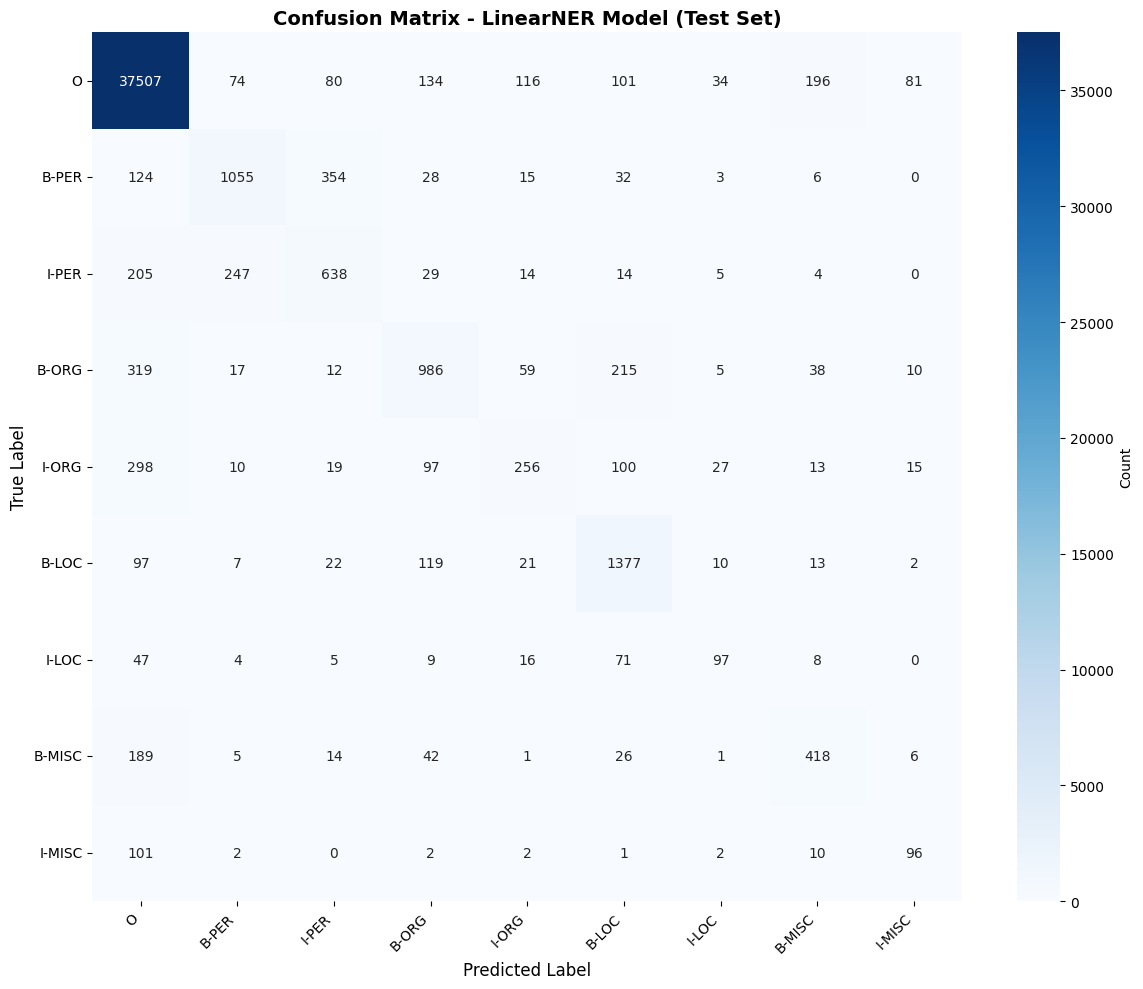


Top 10 Most Common Prediction Errors
True: B-PER      -> Predicted: I-PER      | Count: 354
True: B-ORG      -> Predicted: O          | Count: 319
True: I-ORG      -> Predicted: O          | Count: 298
True: I-PER      -> Predicted: B-PER      | Count: 247
True: B-ORG      -> Predicted: B-LOC      | Count: 215
True: I-PER      -> Predicted: O          | Count: 205
True: O          -> Predicted: B-MISC     | Count: 196
True: B-MISC     -> Predicted: O          | Count: 189
True: O          -> Predicted: B-ORG      | Count: 134
True: B-PER      -> Predicted: O          | Count: 124


In [12]:
# Token-level confusion matrix visualization
from sklearn.metrics import confusion_matrix

# Confusion matrix for test set
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=tag_names, yticklabels=tag_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - LinearNER Model (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyze most common errors
print("\n" + "=" * 60)
print("Top 10 Most Common Prediction Errors")
print("=" * 60)
errors = []
for i in range(len(tag_names)):
    for j in range(len(tag_names)):
        if i != j and cm[i, j] > 0:
            errors.append((tag_names[i], tag_names[j], cm[i, j]))

errors.sort(key=lambda x: x[2], reverse=True)
for true_tag, pred_tag, count in errors[:10]:
    print(f"True: {true_tag:10s} -> Predicted: {pred_tag:10s} | Count: {count}")

idee: see relative rates for each miscalculated label. like a confusion matrix but with percentages

2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 

In [34]:
class MLPNER(nn.Module):
    """
    Multi-layer perceptron for Named Entity Recognition using GloVe embeddings.
    Architecture: Embedding -> MLP (hidden layers) -> Logits
    """
    def __init__(self, embedding_matrix: torch.Tensor, num_tags: int, 
                 hidden_dims: list = [256, 128], dropout: float = 0.5):
        """
        Args:
            embedding_matrix: Pre-trained GloVe embeddings
            num_tags: Number of NER tags (end dimension)
            hidden_dims: List of hidden layer dimensions (e.g., [256, 128] for 2 layers)
            dropout: Dropout probability for regularization, 0.5 because the paper I think used that
        """
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        
        # Embedding layer (same as before)
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        with torch.no_grad():
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()
        
        # Build MLP layers using nn.Sequential
        # i love it
        layers = []
        input_dim = embed_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        
        # L'asterisco * è l'operatore di "unpacking" (spacchettamento) di Python.
        # Prende la lista layers e "spacchetta" il suo contenuto, passando ogni elemento
        # della lista come un argomento separato a nn.Sequential
        self.mlp = nn.Sequential(*layers)
        
        # Final classifier
        self.classifier = nn.Linear(input_dim, num_tags)
    
    def forward(self, input_ids):
        """
        Args:
            input_ids: (batch_size, sequence_length)
        Returns:
            logits: (batch_size, sequence_length, num_tags)
        """
        # using the glove embeddings
        emb = self.embedding(input_ids)        # (B, T, D)
        # pass through MLP
        hidden = self.mlp(emb)                 # (B, T, H)
        # pass through final classifier
        logits = self.classifier(hidden)       # (B, T, C)
        return logits
    

# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# Initialize model with pre-trained GloVe embeddings
# using defaults this is now a 2-layer MLP with 256 and 128 hidden units
model_2layer = MLPNER(embedding_matrix, num_tags)

# CrossEntropyLoss with ignore_index=-100 to skip padding tokens in loss calculation
# its also very comoda perchè prende i logit e le label
# change for mlp?
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Adam optimizer for parameter updates
# change for mlp?
optimizer = torch.optim.Adam(model_2layer.parameters(), lr=1e-3)

# Move model to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2layer.to(device)

mlp_2layer_epochs = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model_2layer.train()  # Set model to training mode
    total_loss = 0.0
    
    # An epoch is too large to process at once, so it's broken into smaller chunks
    # called batches (handled by your train_dataloader)
    for batch in train_dataloader:
        # Move batch data to device (gpu)
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        # Zero gradients from previous step
        # This line clears the gradients from the previous batch,
        # ensuring we only update the model based on the current batch's error.
        optimizer.zero_grad()
        
        # Forward pass: get predictions
        logits = model_2layer(input_ids)
        
        # Now, the loss function compares the logits for every single token against its corresponding true label. Thanks to ignore_index=-100, any token where the label is -100 is skipped.
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate loss for monitoring
        total_loss += loss.item()
    
    # Print average loss per batch for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_2layer_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.4170
Epoch 2/5 - Train Loss: 0.2398
Epoch 3/5 - Train Loss: 0.2037
Epoch 4/5 - Train Loss: 0.1846
Epoch 5/5 - Train Loss: 0.1737


single layer, normal size

In [35]:
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_onelayer = MLPNER(embedding_matrix, num_tags, hidden_dims=[128])

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model_onelayer.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_onelayer.to(device)

mlp_onelayer_epochs = []

num_epochs = 5
for epoch in range(num_epochs):
    model_onelayer.train()  # Set model_onelayer to training mode
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_onelayer(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_onelayer_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.4335
Epoch 2/5 - Train Loss: 0.2378
Epoch 3/5 - Train Loss: 0.1994
Epoch 4/5 - Train Loss: 0.1789
Epoch 5/5 - Train Loss: 0.1663


3 layer

In [36]:
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_3layer = MLPNER(embedding_matrix, num_tags, hidden_dims=[512,256,128])

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model_3layer.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3layer.to(device)

mlp_3layer_epochs = []

num_epochs = 5
for epoch in range(num_epochs):
    model_3layer.train()  # Set model_3layer to training mode
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_3layer(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_3layer_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.3997
Epoch 2/5 - Train Loss: 0.2394
Epoch 3/5 - Train Loss: 0.2073
Epoch 4/5 - Train Loss: 0.1890
Epoch 5/5 - Train Loss: 0.1777


In [37]:
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_3layer_wide = MLPNER(embedding_matrix, num_tags, hidden_dims=[512,256,256])

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model_3layer_wide.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3layer_wide.to(device)

mlp_3layer_wide_epochs = []

num_epochs = 5
for epoch in range(num_epochs):
    model_3layer_wide.train()  # Set model_3layer_wide to training mode
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_3layer_wide(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_3layer_wide_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.3886
Epoch 2/5 - Train Loss: 0.2326
Epoch 3/5 - Train Loss: 0.2015
Epoch 4/5 - Train Loss: 0.1839
Epoch 5/5 - Train Loss: 0.1748


In [38]:
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 128 units
model_3layer_small = MLPNER(embedding_matrix, num_tags, hidden_dims=[128,128,128])

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model_3layer_small.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3layer_small.to(device)

mlp_3layer_small_epochs = []

num_epochs = 5
for epoch in range(num_epochs):
    model_3layer_small.train()  # Set model_3layer_small to training mode
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_3layer_small(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_3layer_small_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.4919
Epoch 2/5 - Train Loss: 0.2814
Epoch 3/5 - Train Loss: 0.2370
Epoch 4/5 - Train Loss: 0.2131
Epoch 5/5 - Train Loss: 0.1995


In [39]:
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 512 units
model_onelayer_wide = MLPNER(embedding_matrix, num_tags, hidden_dims=[512])

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model_onelayer_wide.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_onelayer_wide.to(device)

mlp_onelayer_wide_epochs = []

num_epochs = 5
for epoch in range(num_epochs):
    model_onelayer_wide.train()  # Set model_onelayer_wide to training mode
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_onelayer_wide(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_onelayer_wide_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.3511
Epoch 2/5 - Train Loss: 0.2049
Epoch 3/5 - Train Loss: 0.1759
Epoch 4/5 - Train Loss: 0.1612
Epoch 5/5 - Train Loss: 0.1521


il 3-layer descending layer size didnt perform as good as i would have thought

In [40]:
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 512 units
model_3layer_bottleneck = MLPNER(embedding_matrix, num_tags, hidden_dims=[256,64,128])

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model_3layer_bottleneck.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3layer_bottleneck.to(device)

mlp_3layer_bottleneck_epochs = []

num_epochs = 5
for epoch in range(num_epochs):
    model_3layer_bottleneck.train()  # Set model_3layer_bottleneck to training mode
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_3layer_bottleneck(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_3layer_bottleneck_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.4821
Epoch 2/5 - Train Loss: 0.2796
Epoch 3/5 - Train Loss: 0.2408
Epoch 4/5 - Train Loss: 0.2187
Epoch 5/5 - Train Loss: 0.2030


In [41]:
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# single hidden layer with 512 units
model_5layers = MLPNER(embedding_matrix, num_tags, hidden_dims=[256,128,64,32,16])

"""
Too aggressive compression: 100 → 256 → 16 is a 16× reduction
Information bottleneck: The final 16-dim layer may lose important features before classification
Vanishing gradients: 5 layers is deep for token-level tasks without residual connections
Overfitting risk: Many parameters but final layer too narrow
"""

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model_5layers.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_5layers.to(device)

mlp_5layers_epochs = []

num_epochs = 5
for epoch in range(num_epochs):
    model_5layers.train()  # Set model_5layers to training mode
    total_loss = 0.0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_5layers(input_ids)
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")
    mlp_5layers_epochs.append(total_loss/len(train_dataloader))

Epoch 1/5 - Train Loss: 0.6206
Epoch 2/5 - Train Loss: 0.4162
Epoch 3/5 - Train Loss: 0.3833
Epoch 4/5 - Train Loss: 0.3626
Epoch 5/5 - Train Loss: 0.3486


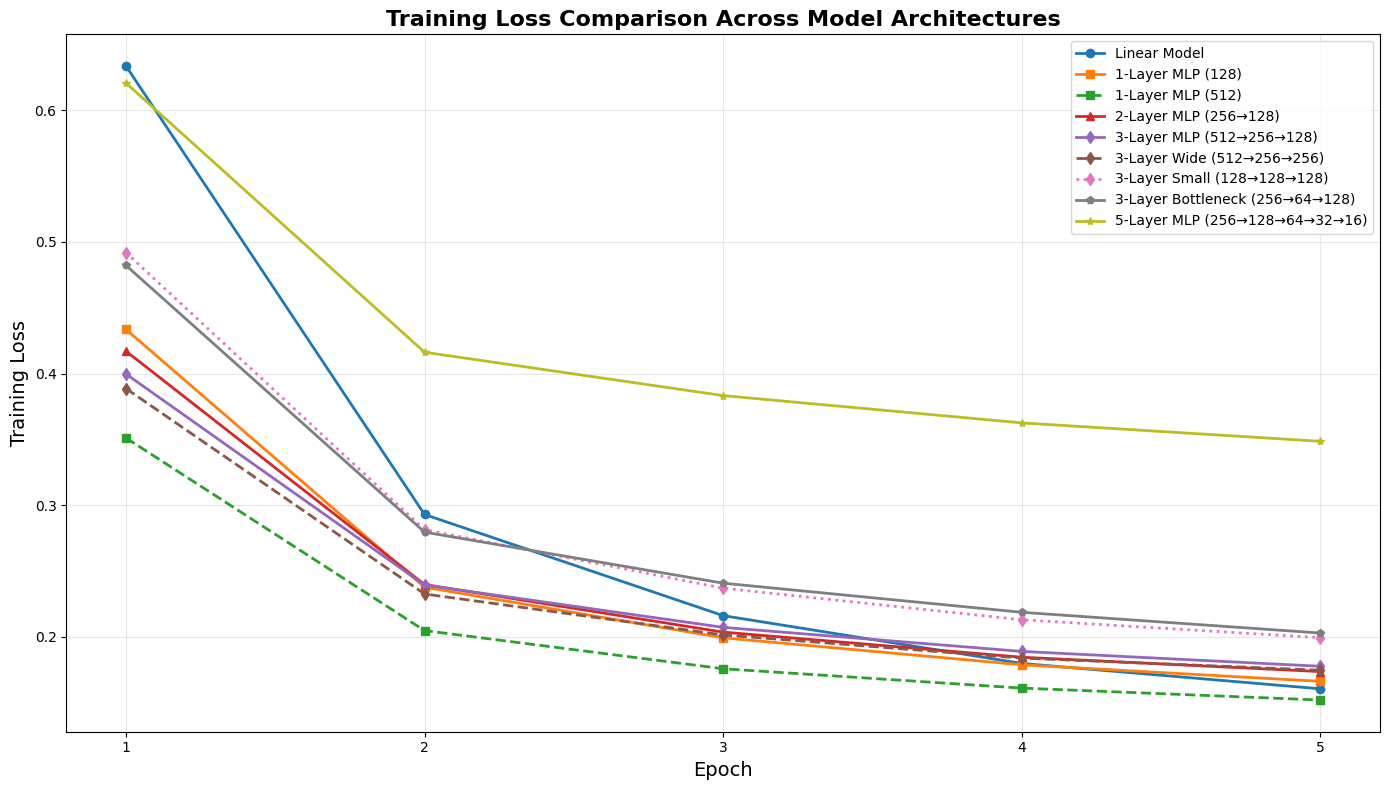

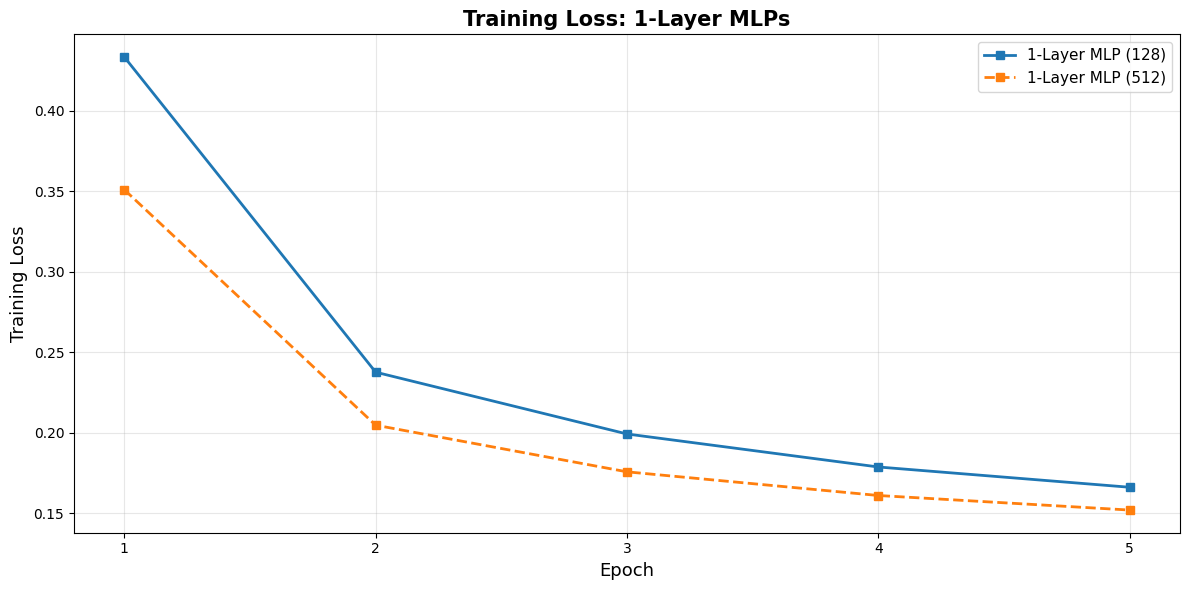

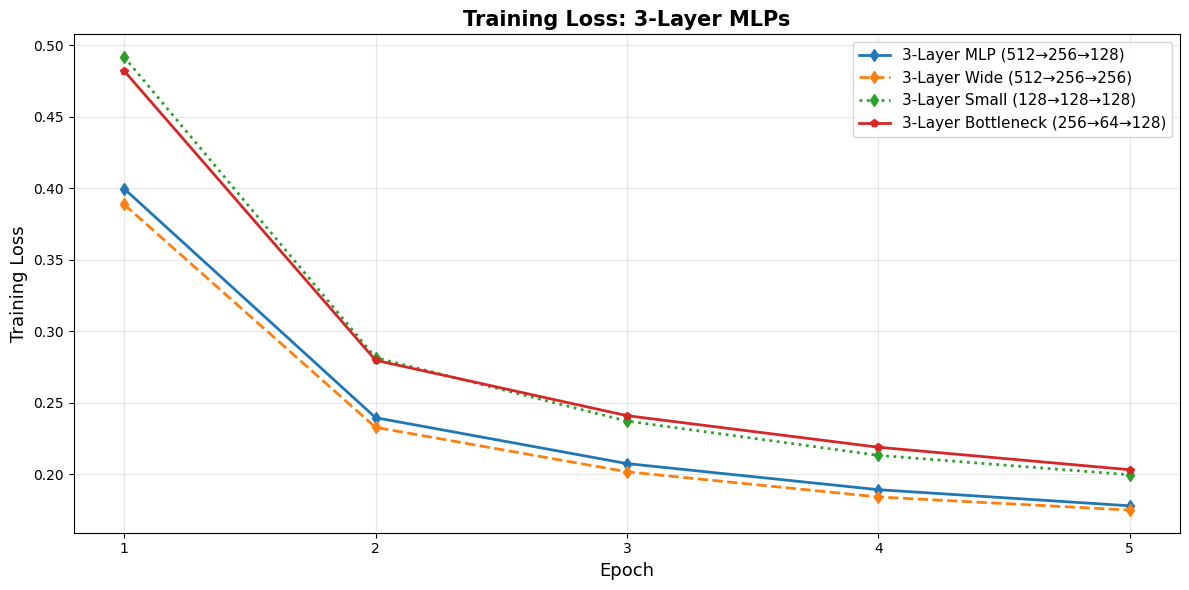


Final Training Loss (Epoch 5)
Linear Model:                0.1606
1-Layer MLP (128):           0.1663
1-Layer MLP (512):           0.1521
2-Layer MLP (256→128):       0.1737
3-Layer MLP (512→256→128):   0.1777
3-Layer Wide (512→256→256):  0.1748
3-Layer Small (128³):        0.1995
3-Layer Bottleneck:          0.2030
5-Layer MLP:                 0.3486


In [48]:
# Visualize training loss for all models
plt.figure(figsize=(14, 8))

# Plot each model's training loss
plt.plot(range(1, num_epochs + 1), linear_epochs, marker='o', label='Linear Model', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_onelayer_epochs, marker='s', label='1-Layer MLP (128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_onelayer_wide_epochs, marker='s', label='1-Layer MLP (512)', linewidth=2, linestyle='--')
plt.plot(range(1, num_epochs + 1), mlp_2layer_epochs, marker='^', label='2-Layer MLP (256→128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_3layer_epochs, marker='d', label='3-Layer MLP (512→256→128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_3layer_wide_epochs, marker='d', label='3-Layer Wide (512→256→256)', linewidth=2, linestyle='--')
plt.plot(range(1, num_epochs + 1), mlp_3layer_small_epochs, marker='d', label='3-Layer Small (128→128→128)', linewidth=2, linestyle=':')
plt.plot(range(1, num_epochs + 1), mlp_3layer_bottleneck_epochs, marker='p', label='3-Layer Bottleneck (256→64→128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_5layers_epochs, marker='*', label='5-Layer MLP (256→128→64→32→16)', linewidth=2)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.title('Training Loss Comparison Across Model Architectures', fontsize=16, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# Separate plots focusing on models with same amount of layers
# 1-Layer MLPs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), mlp_onelayer_epochs, marker='s', label='1-Layer MLP (128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_onelayer_wide_epochs, marker='s', label='1-Layer MLP (512)', linewidth=2, linestyle='--')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Training Loss', fontsize=13)
plt.title('Training Loss: 1-Layer MLPs', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# 3-Layer MLPs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), mlp_3layer_epochs, marker='d', label='3-Layer MLP (512→256→128)', linewidth=2)
plt.plot(range(1, num_epochs + 1), mlp_3layer_wide_epochs, marker='d', label='3-Layer Wide (512→256→256)', linewidth=2, linestyle='--')
plt.plot(range(1, num_epochs + 1), mlp_3layer_small_epochs, marker='d', label='3-Layer Small (128→128→128)', linewidth=2, linestyle=':')
plt.plot(range(1, num_epochs + 1), mlp_3layer_bottleneck_epochs, marker='p', label='3-Layer Bottleneck (256→64→128)', linewidth=2)
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Training Loss', fontsize=13)
plt.title('Training Loss: 3-Layer MLPs', fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

# Print final losses for comparison
print("\n" + "=" * 60)
print("Final Training Loss (Epoch 5)")
print("=" * 60)
print(f"Linear Model:                {linear_epochs[-1]:.4f}")
print(f"1-Layer MLP (128):           {mlp_onelayer_epochs[-1]:.4f}")
print(f"1-Layer MLP (512):           {mlp_onelayer_wide_epochs[-1]:.4f}")
print(f"2-Layer MLP (256→128):       {mlp_2layer_epochs[-1]:.4f}")
print(f"3-Layer MLP (512→256→128):   {mlp_3layer_epochs[-1]:.4f}")
print(f"3-Layer Wide (512→256→256):  {mlp_3layer_wide_epochs[-1]:.4f}")
print(f"3-Layer Small (128³):        {mlp_3layer_small_epochs[-1]:.4f}")
print(f"3-Layer Bottleneck:          {mlp_3layer_bottleneck_epochs[-1]:.4f}")
print(f"5-Layer MLP:                 {mlp_5layers_epochs[-1]:.4f}")

f1_score for all models

In [54]:
#print("\nEvaluating original linear model:")
#entity_level_evaluation(model)
#print()
#print("\nEvaluating 2-layer MLP model:")
#entity_level_evaluation(model_2layer)
#print()
#print("\nEvaluating 1-layer MLP model:")
#entity_level_evaluation(model_onelayer)
#print()
#print("\nEvaluating 3-layer MLP model:")
#entity_level_evaluation(model_3layer)
#print()
#print("\nEvaluating 3-layer Wide MLP model:")
#entity_level_evaluation(model_3layer_wide)
#print()
#print("\nEvaluating 3-layer Small MLP model:")
#entity_level_evaluation(model_3layer_small)
#print()
#print("\nEvaluating 1-layer Wide MLP model:")
#entity_level_evaluation(model_onelayer_wide)
#print()
#print("\nEvaluating 3-layer Bottleneck MLP model:")
#entity_level_evaluation(model_3layer_bottleneck)
#print()
#print("\nEvaluating 5-layer MLP model:")
#entity_level_evaluation(model_5layers)

In [50]:
# Collect metrics for all models
print("Collecting metrics for all models...")
model_results = {
    'Linear': entity_level_evaluation(model, verbose=False),
    '1-Layer (128)': entity_level_evaluation(model_onelayer, verbose=False),
    '1-Layer (512)': entity_level_evaluation(model_onelayer_wide, verbose=False),
    '2-Layer': entity_level_evaluation(model_2layer, verbose=False),
    '3-Layer': entity_level_evaluation(model_3layer, verbose=False),
    '3-Layer Wide': entity_level_evaluation(model_3layer_wide, verbose=False),
    '3-Layer Small': entity_level_evaluation(model_3layer_small, verbose=False),
    '3-Layer Bottleneck': entity_level_evaluation(model_3layer_bottleneck, verbose=False),
    '5-Layer': entity_level_evaluation(model_5layers, verbose=False),
}

model_names = list(model_results.keys())
val_f1 = [model_results[m]['val']['f1'] for m in model_names]
test_f1 = [model_results[m]['test']['f1'] for m in model_names]
val_precision = [model_results[m]['val']['precision'] for m in model_names]
test_precision = [model_results[m]['test']['precision'] for m in model_names]
val_recall = [model_results[m]['val']['recall'] for m in model_names]
test_recall = [model_results[m]['test']['recall'] for m in model_names]

Evaluating: 100%|██████████| 108/108 [00:00<00:00, 367.77it/s]


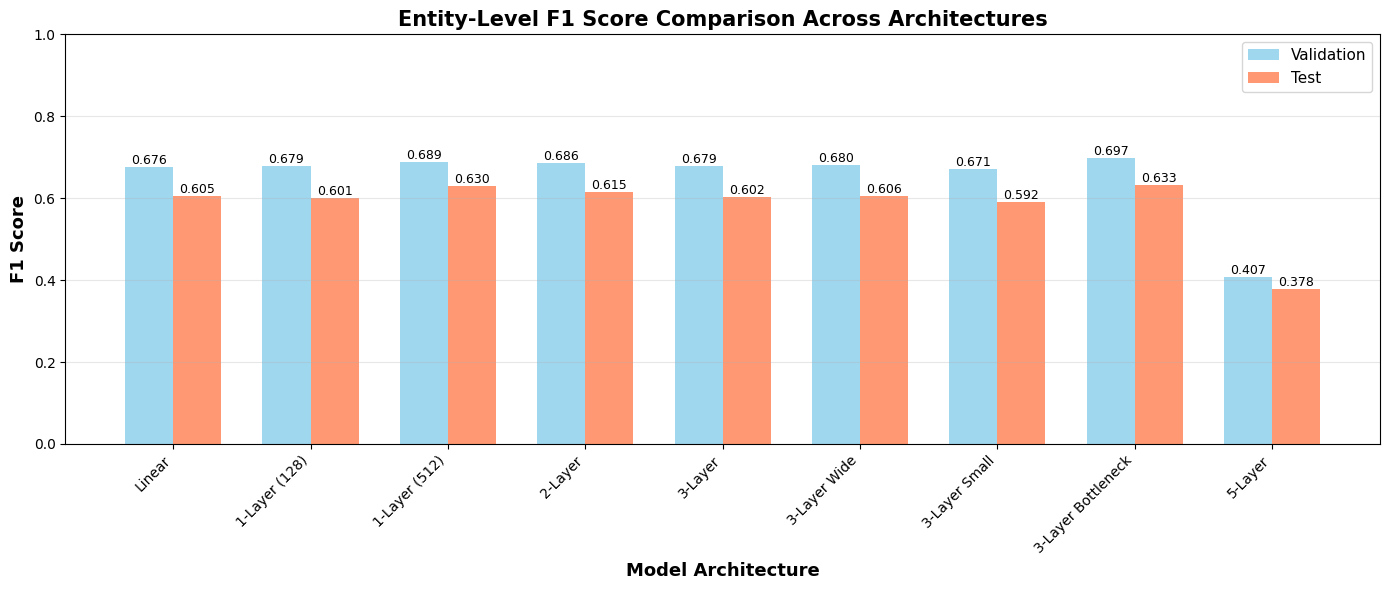

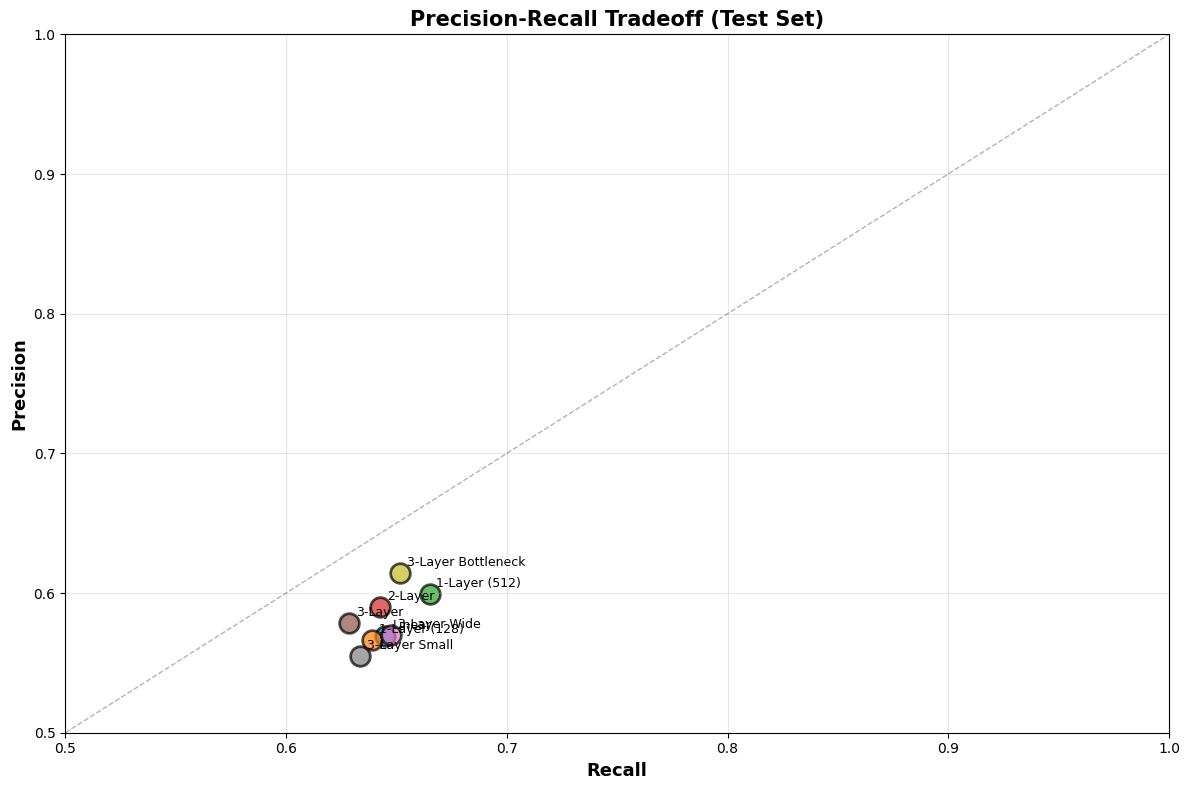

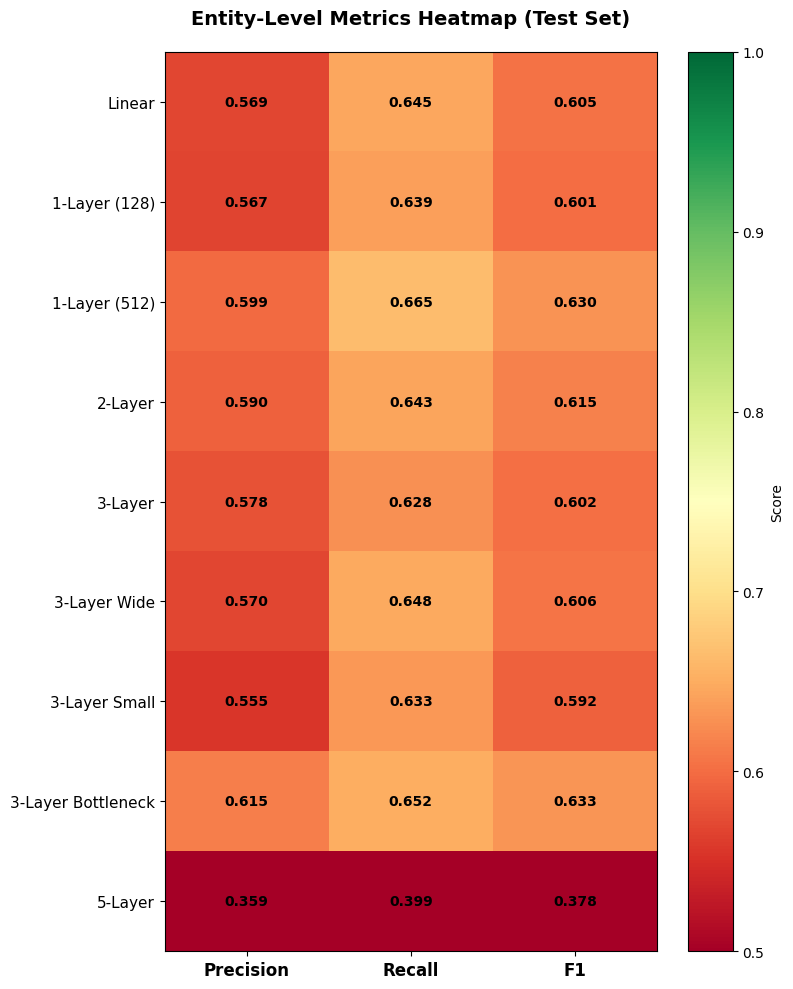


Model                     Val F1     Test F1    Test Prec    Test Recall 
Linear                    0.6763     0.6047     0.5692       0.6450      
1-Layer (128)             0.6785     0.6008     0.5667       0.6392      
1-Layer (512)             0.6893     0.6303     0.5990       0.6650      
2-Layer                   0.6857     0.6153     0.5901       0.6427      
3-Layer                   0.6790     0.6023     0.5784       0.6284      
3-Layer Wide              0.6798     0.6063     0.5699       0.6477      
3-Layer Small             0.6706     0.5917     0.5552       0.6335      
3-Layer Bottleneck        0.6971     0.6326     0.6146       0.6517      
5-Layer                   0.4074     0.3777     0.3587       0.3987      

Best Model (Test F1): 3-Layer Bottleneck (F1: 0.6326)


In [53]:
# 1. F1 Score Comparison
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(model_names))
width = 0.35

bars1 = ax.bar(x - width/2, val_f1, width, label='Validation', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, test_f1, width, label='Test', alpha=0.8, color='coral')

ax.set_xlabel('Model Architecture', fontsize=13, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
ax.set_title('Entity-Level F1 Score Comparison Across Architectures', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# 2. Precision-Recall Tradeoff (Test Set)
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

for i, (name, color) in enumerate(zip(model_names, colors)):
    ax.scatter(test_recall[i], test_precision[i], s=200, c=[color], 
               alpha=0.7, edgecolors='black', linewidth=2, label=name)
    ax.annotate(name, (test_recall[i], test_precision[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Tradeoff (Test Set)', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
# Diagonal line (F1 isolines could be added)
ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()


# 3. Comprehensive Metrics Heatmap
metrics_matrix = []
for name in model_names:
    row = [
        model_results[name]['test']['precision'],
        model_results[name]['test']['recall'],
        model_results[name]['test']['f1']
    ]
    metrics_matrix.append(row)

fig, ax = plt.subplots(figsize=(8, 10))
im = ax.imshow(metrics_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1)

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(len(model_names)))
ax.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=12, fontweight='bold')
ax.set_yticklabels(model_names, fontsize=11)

# Add text annotations
for i in range(len(model_names)):
    for j in range(3):
        text = ax.text(j, i, f'{metrics_matrix[i][j]:.3f}',
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

ax.set_title('Entity-Level Metrics Heatmap (Test Set)', fontsize=14, fontweight='bold', pad=20)
fig.colorbar(im, ax=ax, label='Score')
plt.tight_layout()
plt.show()


# 4. Summary Table
print("\n" + "=" * 90)
print(f"{'Model':<25} {'Val F1':<10} {'Test F1':<10} {'Test Prec':<12} {'Test Recall':<12}")
print("=" * 90)
for name in model_names:
    print(f"{name:<25} "
          f"{model_results[name]['val']['f1']:<10.4f} "
          f"{model_results[name]['test']['f1']:<10.4f} "
          f"{model_results[name]['test']['precision']:<12.4f} "
          f"{model_results[name]['test']['recall']:<12.4f}")
print("=" * 90)

# Find best model
best_model = max(model_names, key=lambda x: model_results[x]['test']['f1'])
print(f"\nBest Model (Test F1): {best_model} (F1: {model_results[best_model]['test']['f1']:.4f})")